In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build an Autoencoder for a human face dataset

We will use a dataset containig images of people and train an autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [20]:

path = 'C:\\Users\\Eswar Nagu Pulipati\\Downloads\\lfw'

In [21]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [26]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")

MPS device not found.


In [28]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA (GPU)")
else:
    device = torch.device("cpu")
    print("CUDA not available, using CPU")


Using CUDA (GPU)


torch.Size([250, 250, 3])


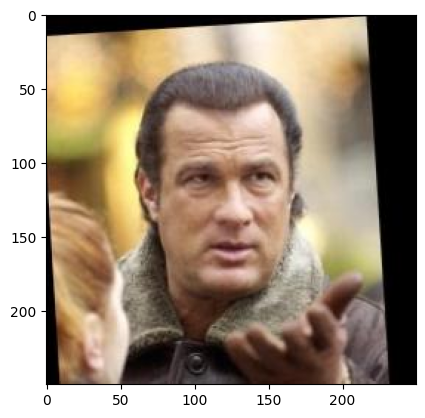

In [29]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

## Step 2
Each datapoint is an image. Get a sample of the data and print its dimensions and explain what each dimension means.

# Step 3

Create a new pytorch model calss for your autoencoder. You can use Conv2d, MaxPool2d, BatchNorm2d, ConvTranspose2d and Linear Layers as as well as activation functions. Optionally, you can use UpSample, AveragePool2d and Interpolate2d as well.

**Create seperate functions for the encoder and decoder.**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdvancedAE(nn.Module):
    def __init__(self):
        super(AdvancedAE, self).__init__()

        # Define encoder convolutional layers
        self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.enc_pool1 = nn.MaxPool2d(2)  # Downsampling
        self.enc_bn1 = nn.BatchNorm2d(16)
        self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.enc_pool2 = nn.MaxPool2d(2)  # Downsampling
        self.enc_bn2 = nn.BatchNorm2d(32)
        self.enc_conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc_pool3 = nn.MaxPool2d(2)  # Downsampling
        self.enc_bn3 = nn.BatchNorm2d(64)

        # Automatically calculate flatten size
        self.flatten_size = self._get_flatten_size()

        # Define encoder linear layer
        self.enc_linear = nn.Linear(self.flatten_size, 256)

        # Define decoder linear layer and transposed convolutional layers
        self.dec_linear = nn.Linear(256, self.flatten_size)
        self.dec_upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(32)
        self.dec_upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv2 = nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(16)
        self.dec_upsample3 = nn.Upsample(scale_factor=2, mode='nearest')
        self.dec_conv3 = nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1)

    def _get_flatten_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 250, 250)
            dummy_output = self._forward_conv_layers(dummy_input)
            flatten_size = dummy_output.view(-1).shape[0]
            return flatten_size

    def _forward_conv_layers(self, x):
        # Pass x through all conv and pooling layers
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_pool1(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = self.enc_pool2(x)
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        x = self.enc_pool3(x)
        return x

    def encoder(self, x):
        x = self._forward_conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.enc_linear(x))
        return x


    def decoder(self, x):
        x = F.relu(self.dec_linear(x))

        # Calculate the spatial dimensions for reshaping
        spatial_dim = int((self.flatten_size / 64) ** 0.5)
        x = x.view(x.size(0), 64, spatial_dim, spatial_dim)

        # Add transposed convolution layers with the correct number of channels
        x = self.dec_upsample1(x)
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = self.dec_upsample2(x)
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = self.dec_upsample3(x)

        # Adjust the number of channels in the transposed convolution layer
        x = self.dec_conv3(x)
        
        # Apply upsampling to match the input image dimensions (250x250)
        x = F.interpolate(x, size=(250, 250), mode='bilinear', align_corners=False)

        # The following line is fine and should remain the same
        x = torch.sigmoid(x)
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


## Step 4
Create an instance of the class, pass an image to the model, print the shape of the output of the **encoder** and the **decoder**. Check the dimensions and make sure your forward path is working properly.

In [13]:
# Step 1: Create an instance of the model
model = AdvancedAE()

# Create a dummy input image
# For a single 250x250 RGB image, the input tensor shape should be [1, 3, 250, 250]
dummy_input = torch.randn(1, 3, 250, 250)

# Pass the dummy input through the model
encoded = model.encoder(dummy_input)
decoded = model.decoder(encoded)

# Print the shapes of the outputs
print("Encoded Shape:", encoded.shape)
print("Decoded Shape:", decoded.shape)

output = model(dummy_input)
print("Output Shape (from forward pass):", output.shape)

Encoded Shape: torch.Size([1, 64, 32, 32])
Decoded Shape: torch.Size([1, 3, 256, 256])


##  Step 5
Print total number of parameters in the model, explain what loss function you should use, create an optimizer for training

In [14]:
import torch.optim as optim

total_trainable_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print("Total trainable parameters in the model:", total_trainable_params)

# Mean Squared Error (MSE) is typically used for autoencoders
mse_loss = nn.MSELoss()

# Using the Adam optimizer with a standard learning rate
adam_optimizer = optim.Adam(model.parameters(), lr=0.001)

# Displaying the chosen loss function and optimizer
print("Chosen Loss Function:", mse_loss)
print("Configured Optimizer:", adam_optimizer)


Total number of trainable parameters: 47427
Loss Function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


##  Step 6
Write a training loop and start trainng the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [17]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Custom ImageFolder for handling image loading errors
class CustomImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        while True:
            try:
                sample = self.loader(path)
                break
            except Image.UnidentifiedImageError:
                # Skip this file and move to the next one
                index = (index + 1) % len(self.samples)
                path, target = self.samples[index]

        if self.transform is not None:
            sample = self.transform(sample)

        return sample, target

# Dataset and DataLoader
transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

# Model, Optimizer, and Loss Function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AdvancedAE().to(device)  # Replace AE with the actual name of your model class if different
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
loss_function = nn.MSELoss()  # Defining the loss function

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    total_batches = 0

    for images, _ in dataloader:
        images = images.to(device)

        # Forward pass
        reconstructed = model(images)
        loss = loss_function(reconstructed, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_batches += 1

    # Update the learning rate
    scheduler.step()

    # Calculate and print average loss per batch
    avg_loss = total_loss / total_batches
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 0.0144
Epoch [2/10], Loss: 0.0019
Epoch [3/10], Loss: 0.0014
Epoch [4/10], Loss: 0.0012
Epoch [5/10], Loss: 0.0011
Epoch [6/10], Loss: 0.0009
Epoch [7/10], Loss: 0.0009
Epoch [8/10], Loss: 0.0008
Epoch [9/10], Loss: 0.0007
Epoch [10/10], Loss: 0.0008


##  Step 7

Take a random image from the dataset and plot it against the reconstructed (encoded + decoded) image.

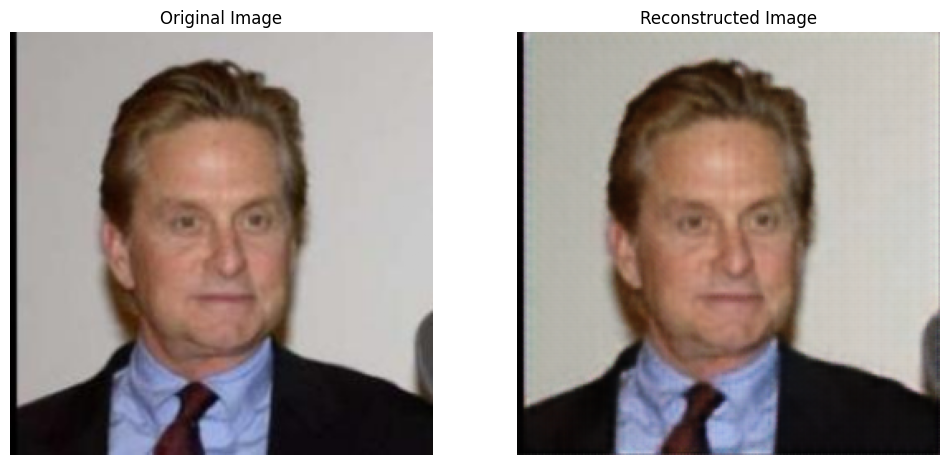

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Set the model to evaluation mode
model.eval()

# Get a random batch of images from the dataloader
random_batch = next(iter(dataloader))
images, _ = random_batch

# Select a random image from the batch
random_index = random.randint(0, len(images) - 1)
original_image = images[random_index]

# Move the image to the device and add an extra batch dimension
original_image = original_image.to(device).unsqueeze(0)

# Forward pass through the model to get the reconstructed image
with torch.no_grad():
    reconstructed_image = model(original_image)

# Convert images to numpy for plotting
original_image_np = original_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plotting
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(np.clip(original_image_np, 0, 1))
plt.title('Original Image')
plt.axis('off')

# Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(np.clip(reconstructed_image_np, 0, 1))
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()


##  Step 8

In step 7, add a small normaly distrubuted noise to the latent (hidden) representation of the input image and then decode it again. How is adding noise affecting the decoded image ?

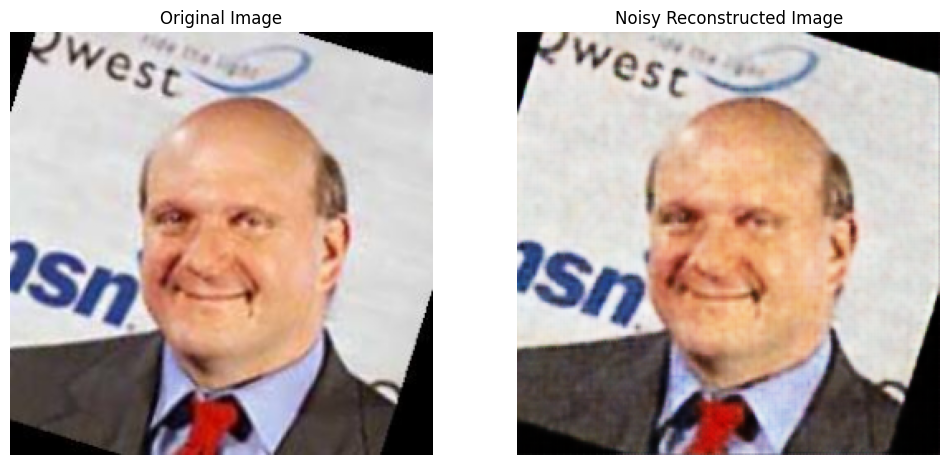

In [19]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# Set the model to evaluation mode
model.eval()

# Get a random batch of images from the dataloader
random_batch = next(iter(dataloader))
images, _ = random_batch

# Select a random image from the batch
random_index = random.randint(0, len(images) - 1)
original_image = images[random_index]

# Move the image to the device and add an extra batch dimension
original_image = original_image.to(device).unsqueeze(0)

# Forward pass through the encoder
with torch.no_grad():
    encoded_image = model.encoder(original_image)

# Add Gaussian noise to the encoded image
noise = torch.randn_like(encoded_image) * 0.1  # Adjust the noise level as needed
noisy_encoded_image = encoded_image + noise

# Forward pass through the decoder
noisy_reconstructed_image = model.decoder(noisy_encoded_image)

# Convert images to numpy for plotting
original_image_np = original_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
noisy_reconstructed_image_np = noisy_reconstructed_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

# Plotting
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(np.clip(original_image_np, 0, 1))
plt.title('Original Image')
plt.axis('off')

# Noisy Reconstructed Image
plt.subplot(1, 2, 2)
plt.imshow(np.clip(noisy_reconstructed_image_np, 0, 1))
plt.title('Noisy Reconstructed Image')
plt.axis('off')

plt.show()
